<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/angelo_albumentations/STEP_4B_PIDNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [ ]:
!pip install torchmetrics
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unin

In [ ]:
from google.colab import drive
import os

!git clone -b angelo_albumentations --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

Cloning into 'AML_2025_project4'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 112 (delta 10), reused 6 (delta 6), pack-reused 88 (from 1)
Receiving objects: 100% (112/112), 21.14 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Mounted at /content/drive


In [ ]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [ ]:
import tqdm

from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Extracting training...
training extracted!
Extracting validation...
validation extracted!
Extraction check completed!
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [ ]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

RESIZE = 512

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

STEP_SIZE = 5

GAMMA = 0.1

LR = 0.01

P = 0.5 # probabilità augmentation

# Define and instantiate

### Define PIDnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

## DACS code

In [ ]:
def create_ema_model(model):

    """Returns a new model that is used to generate pseudo-labels"""

    ema_model = Res_Deeplab(num_classes=num_classes)

    for param in ema_model.parameters():
        param.detach_()
    mp = list(model.parameters())
    mcp = list(ema_model.parameters())
    n = len(mp)
    for i in range(0, n):
        mcp[i].data[:] = mp[i].data[:].clone()
    #_, availble_gpus = self._get_available_devices(self.config['n_gpu'])
    #ema_model = torch.nn.DataParallel(ema_model, device_ids=availble_gpus)
    #if len(gpus)>1:
    #    #return torch.nn.DataParallel(ema_model, device_ids=gpus)
    #    if use_sync_batchnorm:
    #        ema_model = convert_model(ema_model)
    #        ema_model = DataParallelWithCallback(ema_model, device_ids=gpus)
    #    else:
    #        ema_model = torch.nn.DataParallel(ema_model, device_ids=gpus)
    return ema_model


def update_ema_variables(ema_model, model, alpha_teacher, iteration):
    # Use the "true" average until the exponential average is more correct
    alpha_teacher = min(1 - 1 / (iteration + 1), alpha_teacher)
    #if len(gpus)>1:
    #    for ema_param, param in zip(ema_model.module.parameters(), model.module.parameters()):
    #        #ema_param.data.mul_(alpha).add_(1 - alpha, param.data)
    #        ema_param.data[:] = alpha_teacher * ema_param[:].data[:] + (1 - alpha_teacher) * param[:].data[:]
    #else:
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        #ema_param.data.mul_(alpha).add_(1 - alpha, param.data)
        ema_param.data[:] = alpha_teacher * ema_param[:].data[:] + (1 - alpha_teacher) * param[:].data[:]
    return ema_model

# Dataset & dataloader

## Dataset definition

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform, augmentation=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.augmentation = augmentation

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])


        # Read an image with OpenCV
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)


        if self.augmentation:
          transformed = self.augmentation(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]


        mask_np = np.array(mask)

        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        return image, mask, boundaries_tensor  # Return (image, mask) pair

class UnlabeledSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

## Define transformations
(using albumentations)

In [ ]:
# Define transformations for images & masks
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2 as T
import cv2
import itertools


resize_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE, p=1),
    A.ToFloat(),
    ToTensorV2()
])

alb_aug3 = A.HueSaturationValue(
    hue_shift_limit=20,
    sat_shift_limit=30,
    val_shift_limit=20,
    p=P
)

# Selezione delle 6 combinazioni specifiche
augmentations = [
    A.Compose([alb_aug3]),  # Solo hue, saturation, value
]

## Dataset instantiation

In [ ]:
# Create dataset objects
DOMAIN_SHIFT = True

train_datasets = []

for i, augmentation in enumerate(augmentations):

  train_dataset = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                      transform=resize_transform, augmentation=augmentation)
  train_datasets.append(train_dataset)

if not DOMAIN_SHIFT:
  val_dataset = SegmentationDataset(VAL_PATH_URBAN + "/images_png", VAL_PATH_URBAN + "/masks_png",
                                    transform=resize_transform)
else:
  val_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=resize_transform)

## DACS Dataset

In [ ]:
# Dataset Source: LoveDA Urban (with labels)
source_dataset = SegmentationDataset(
    TRAINING_PATH_URBAN + "/images_png",
    TRAINING_PATH_URBAN + "/masks_png",
    transform=resize_transform,
    augmentation=3  # the best in the step 3b
)

# Dataset Target: LoveDA Rural (no labels)
target_dataset = UnlabeledSegmentationDataset(
    TRAINING_PATH_RURAL + "/images_png",
    transform=resize_transform
)

## Loader instantiation

In [ ]:
# Create DataLoaders
train_loaders = []

for dataset in train_datasets:
  train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
  train_loaders.append(train_loader)


train_loader = train_loaders[0] # provo con dataloader modifica saturation hue
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

IndexError: list index out of range

In [ ]:
from utils import show
from matplotlib import pyplot as plt

batch = next(iter(train_loader))  # (images, masks, boundaries)
images, masks, boundaries = batch  # Unpack the batch

fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3 images, each with RGB, mask, and boundary

for i in range(3):  # Show first 3 images

    # Permute the dimensions of the image tensor to (height, width, channels)
    image_np = images[i].cpu().numpy().transpose(1, 2, 0)

    axes[i, 0].imshow(image_np) # Display the image with the correct shape
    axes[i, 0].set_title("Image")

    axes[i, 1].imshow(masks[i].cpu().numpy(), cmap="gray")  # Show mask
    axes[i, 1].set_title("Mask")

    axes[i, 2].imshow(boundaries[i].cpu().numpy(), cmap="gray")  # Show boundaries
    axes[i, 2].set_title("Boundaries")

plt.tight_layout()
plt.show()

### DACS Loader

In [ ]:
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
target_loader_iter = iter(target_loader)

### Instantiate model

In [ ]:
import gdown

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)

  print("imagenet-pretrained pidnet weights downloaded")


class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)
next(model.parameters()).device

# Instanzia n modelli (uno per ogni dataloader)
models = [get_seg_model(cfg, imgnet_pretrained=True) for _ in train_loaders]

### Instantiate EMA model

In [ ]:
# init ema-model
train_unlabeled = True
if train_unlabeled:
    ema_model = create_ema_model(model)
    ema_model.train()
    ema_model = ema_model.cuda()
else:
    ema_model = None

# Training Phase

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print(device);

cuda


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Extra Semantic Loss (Classica CrossEntropy Loss)
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target):
        return self.loss(pred, target)

# 2. Weighted Binary Cross Entropy per i bordi
class WeightedBinaryCrossEntropy(nn.Module):
    def __init__(self, pos_weight=20.0):  # Peso λ1 sui bordi
        super(WeightedBinaryCrossEntropy, self).__init__()
        self.loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))

    def forward(self, pred, target):
        return self.loss(pred, target)

# 3. Boundary-Aware CrossEntropy Loss
class BoundaryAwareCELoss(nn.Module):
    def __init__(self, weight=None):
        super(BoundaryAwareCELoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=-1)

    def forward(self, pred, target, boundary_mask):
        ce_loss = self.loss(pred, target)
        return torch.mean(ce_loss * boundary_mask)  # Pesa i bordi

# 4. BAS-Loss per segmentazione e detection dei bordi
class BASLoss(nn.Module):
    def __init__(self, threshold=0.8):
        super(BASLoss, self).__init__()
        self.threshold = threshold

    def forward(self, boundary_head, pred, target):
        boundary_mask = (boundary_head > self.threshold).float()  # Maschera bordi
        log_probs = F.log_softmax(pred, dim=1)

        # Reshape per compatibilità
        batch_size, num_classes, H, W = log_probs.shape
        log_probs = log_probs.permute(0, 2, 3, 1).reshape(-1, num_classes)  # [B*H*W, num_classes]
        target = target.reshape(-1)  # [B*H*W]
        boundary_mask = boundary_mask.reshape(-1)  # [B*H*W]

        # Applica la perdita solo ai bordi
        loss = -torch.sum(boundary_mask * log_probs[torch.arange(target.shape[0]), target])

        # Normalizza rispetto al numero di pixel nei bordi (evita divisioni per 0)
        return loss / (boundary_mask.sum() + 1e-6)

# 5. PIDNet Loss Totale
class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8):
        super(PIDNetLoss, self).__init__()
        self.ce_loss = CrossEntropyLoss()
        self.wbce_loss = WeightedBinaryCrossEntropy(pos_weight=lambda_1)
        self.boundary_ce_loss = BoundaryAwareCELoss()
        self.bas_loss = BASLoss(threshold)

        self.lambda_0 = lambda_0
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.lambda_3 = lambda_3

    def forward(self, pred, target, boundary_head, boundary_mask):
        """
        pred: output principale (B, C, H, W)
        target: ground truth segmentazione (B, H, W)
        boundary_head: predizione dei bordi (B, 1, H, W)
        boundary_mask: ground truth dei bordi (B, 1, H, W)
        """
        L0 = self.ce_loss(pred, target)  # Extra Semantic Loss
        L1 = self.wbce_loss(boundary_head, boundary_mask.unsqueeze(1))  # Weighted BCE
        L2 = self.boundary_ce_loss(pred, target, boundary_mask)  # Boundary-Aware CE
        L3 = self.bas_loss(boundary_head, pred, target)  # BAS-Loss

        loss = (self.lambda_0 * L0 +
                self.lambda_1 * L1 +
                self.lambda_2 * L2 +
                self.lambda_3 * L3)

        return loss


In [ ]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU
import torch.nn.functional as F

def update_ema_variables(ema_model, model, alpha_teacher, iteration):
    # Use the "true" average until the exponential average is more correct
    alpha_teacher = min(1 - 1 / (iteration + 1), alpha_teacher)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
      #ema_param.data.mul_(alpha).add_(1 - alpha, param.data)
      ema_param.data[:] = alpha_teacher * ema_param[:].data[:] + (1 - alpha_teacher) * param[:].data[:]
    return ema_model

os.makedirs("/content/drive/MyDrive/AML_project/checkpoints_4B", exist_ok=True)

torch.manual_seed(SEED)

num_classes = 7  # Cambia in base al tuo dataset

miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)
miou_overall = MeanIoU(num_classes=num_classes).to(device)

miou_results = []
model_train_loader = zip(models, train_loaders)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=GAMMA, patience=3, threshold=0.01)

model.to(device)
loss_fn = PIDNetLoss()
target_loader_iter = iter(target_loader)

step = 0

for epoch in range(EPOCHS):
  model.train()
  train_loss = 0

  total_train_samples = 0

  batch_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}", ncols=100)

  for batch, (X_s, y_s, boundary_mask_s) in batch_pbar:
    X_s = X_s.to(device)
    y_s = y_s.to(device)
    boundary_mask_s = boundary_mask_s.to(device)

    try:
      X_t = next(target_loader_iter)
    except StopIteration:
      target_loader_iter = iter(target_loader)
      X_t = next(target_loader_iter)
    X_t = X_t.to(device)

    ema_model.eval()
    with torch.no_grad():
      outputs_t = ema_model(X_t)
      h, w = boundary_mask_s.size(1), boundary_mask_s.size(2)
      for i in range(len(outputs_t)):
        outputs_t[i] = F.interpolate(outputs_t[i], size=(h, w), mode='bilinear', align_corners=True)
      if model.augment:
        _, pred_t, _ = outputs_t
      else:
        pred_t = outputs_t
      pseudo_labels = pred_t.argmax(dim=1)

    model.train()
    outputs_s = model(X_s)
    for i in range(len(outputs_s)):
      outputs_s[i] = F.interpolate(outputs_s[i], size=(h, w), mode='bilinear', align_corners=True)

      if model.augment:
        _, pred_s, boundary_head_s = outputs_s
      else:
        pred_s = outputs_s
        boundary_head_s = None

    output_t2 = model(X_t)
    for i in range(len(output_t2)):
      output_t2[i] = F.interpolate(output_t2[i], size=(h, w), mode='bilinear', align_corners=True)
      if model.augment:
        _, pred_t2, boundary_head_t = output_t2
      else:
        pred_t2 = output_t2
        boundary_head_t = None

    loss_s = loss_fn(pred_s, y_s, boundary_head_s, boundary_mask_s)
    loss_t = loss_fn(pred_t2, pseudo_labels, boundary_head_t, boundary_mask_s)

    loss = loss_s + loss_t

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    update_ema_variables(model, ema_model, 0.999, step)
    step = step + 1

    total_train_samples += X_s.size(0)
    train_loss += loss.item()
    batch_pbar.set_postfix(loss=loss.item())

  avg_train_loss = train_loss / total_train_samples
  print(f"Epoch {epoch+1}/{EPOCHS} - Training Loss: {avg_train_loss}")

  # **Validazione**
  model.eval()
  miou_classes.reset()
  miou_overall.reset()
  val_loss = 0
  total_val_samples = 0

  with torch.inference_mode():
    for X_val, y_val, boundary_mask in val_loader:
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      boundary_mask = boundary_mask.to(device)

      # Output del modello
      outputs = model(X_val)

      for i in range(len(outputs)):
        outputs[i] = F.interpolate(outputs[i], size=(boundary_mask.size(1), boundary_mask.size(2)), mode='bilinear', align_corners=True)

      if model.augment:
        _, pred_val, boundary_head_val = outputs
      else:
        pred_val = outputs
        boundary_head_val = None

      # Calcola le predizioni
      preds = pred_val.argmax(dim=1)  # Shape: (N, H, W)

      # Mask dei pixel validi (classi da 0 a num_classes - 1)
      valid_mask = (y_val >= 0) & (y_val < num_classes)

      # Appiattisci le predizioni e i target solo sui pixel validi
      preds_flat = preds[valid_mask]
      targets_flat = y_val[valid_mask]

      miou_classes.update(preds_flat, targets_flat)
      miou_overall.update(preds_flat, targets_flat)

      # Calcola la loss
      loss = loss_fn(pred_val, y_val, boundary_head_val, boundary_mask)
      val_loss += loss.item()
      total_val_samples += X_val.size(0)

  avg_val_loss = val_loss / total_val_samples
  miou_per_class = miou_classes.compute()
  miou = miou_overall.compute()

  print(f"Epoch {epoch+1}/{EPOCHS} - Validation Loss: {avg_val_loss} - mIoU: {miou}")

  if epoch % 5 == 0:
    print("Learning rate:", scheduler.get_last_lr())

  ## steps the scheduler
  scheduler.step(miou)

checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints_4B/model_DACS_4B.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Modello salvato: {checkpoint_path}")

📊 Processig the model with ID: 0
⚠️ The model with ID: 0, already exist, skipped!
📊 Processig the model with ID: 1


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.50it/s, loss=35.5]

Epoch 1/20 - Training Loss: 1.8518488712376788


Epoch 1/20 - Validation Loss: 1.5837906618272104 - mIoU: 0.18046577274799347
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=29.7]

Epoch 2/20 - Training Loss: 1.8498341104976033


Epoch 2/20 - Validation Loss: 1.5703618911004835 - mIoU: 0.24797271192073822


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=31.4]

Epoch 3/20 - Training Loss: 1.8274485842166888


Epoch 3/20 - Validation Loss: 1.593367015161822 - mIoU: 0.19062481820583344


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.55it/s, loss=35.4]

Epoch 4/20 - Training Loss: 1.8224917068613442


Epoch 4/20 - Validation Loss: 1.6019800939867574 - mIoU: 0.17869499325752258


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=28.5]

Epoch 5/20 - Training Loss: 1.7976867220393513


Epoch 5/20 - Validation Loss: 1.5882586413814175 - mIoU: 0.2753932774066925


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=31.2]

Epoch 6/20 - Training Loss: 1.7932315978211928


Epoch 6/20 - Validation Loss: 1.5943886195459673 - mIoU: 0.30875706672668457
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=24.9]

Epoch 7/20 - Training Loss: 1.7752346613002896


Epoch 7/20 - Validation Loss: 1.6010347239432796 - mIoU: 0.32084375619888306


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=24.8]

Epoch 8/20 - Training Loss: 1.7609329454626592


Epoch 8/20 - Validation Loss: 1.841248554568137 - mIoU: 0.2662777006626129


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.57it/s, loss=43.6]

Epoch 9/20 - Training Loss: 1.762694561770218


Epoch 9/20 - Validation Loss: 2.0004104587339584 - mIoU: 0.18128302693367004


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=32.6]

Epoch 10/20 - Training Loss: 1.7552714611832245


Epoch 10/20 - Validation Loss: 1.6635388097455424 - mIoU: 0.29631784558296204


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=28.9]

Epoch 11/20 - Training Loss: 1.722941896907186


Epoch 11/20 - Validation Loss: 1.7554374433332873 - mIoU: 0.23923590779304504
[0.01]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=32.7]

Epoch 12/20 - Training Loss: 1.702197975765875


Epoch 12/20 - Validation Loss: 1.758735352946866 - mIoU: 0.23660269379615784


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.55it/s, loss=31.7]

Epoch 13/20 - Training Loss: 1.6820504492129422


Epoch 13/20 - Validation Loss: 1.7739224164716658 - mIoU: 0.25188934803009033


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=22.5]

Epoch 14/20 - Training Loss: 1.6641968393820792


Epoch 14/20 - Validation Loss: 1.7550404898581966 - mIoU: 0.28426772356033325


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=23.7]

Epoch 15/20 - Training Loss: 1.6609372878157145


Epoch 15/20 - Validation Loss: 1.745511697184655 - mIoU: 0.24379393458366394


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.57it/s, loss=37.2]

Epoch 16/20 - Training Loss: 1.6628259936006011


Epoch 16/20 - Validation Loss: 1.8466130725799068 - mIoU: 0.27189871668815613
[0.0001]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=21.5]

Epoch 17/20 - Training Loss: 1.656138091763823


Epoch 17/20 - Validation Loss: 1.7229126576454408 - mIoU: 0.2942374348640442


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=25.4]

Epoch 18/20 - Training Loss: 1.6521537922657896


Epoch 18/20 - Validation Loss: 1.8157874768780125 - mIoU: 0.2752760350704193


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.55it/s, loss=30.2]

Epoch 19/20 - Training Loss: 1.6621214048260224


Epoch 19/20 - Validation Loss: 1.820054127324012 - mIoU: 0.28203460574150085


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.60it/s, loss=27.7]

Epoch 20/20 - Training Loss: 1.6585703077613276


Epoch 20/20 - Validation Loss: 1.8595240019982862 - mIoU: 0.25242048501968384
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_new/model_PIDNET_3B_1.pth
📊 Processig the model with ID: 2


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:29<00:00,  2.50it/s, loss=45.6]

Epoch 1/20 - Training Loss: 2.4798259273119863


Epoch 1/20 - Validation Loss: 2.1457792808932643 - mIoU: 0.042990557849407196
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:29<00:00,  2.50it/s, loss=39.9]

Epoch 2/20 - Training Loss: 2.3799669074352225


Epoch 2/20 - Validation Loss: 1.714265940650817 - mIoU: 0.1351758986711502


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:29<00:00,  2.50it/s, loss=39.4]

Epoch 3/20 - Training Loss: 2.2771878258992233


Epoch 3/20 - Validation Loss: 1.7061017424829545 - mIoU: 0.0692594051361084


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:29<00:00,  2.49it/s, loss=39.1]

Epoch 4/20 - Training Loss: 2.268675761239339


Epoch 4/20 - Validation Loss: 1.9293988789281538 - mIoU: 0.12011795490980148


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:29<00:00,  2.50it/s, loss=43.3]

Epoch 5/20 - Training Loss: 2.242370729215417


Epoch 5/20 - Validation Loss: 1.7877895697470634 - mIoU: 0.11275558173656464


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:29<00:00,  2.49it/s, loss=34.5]

Epoch 6/20 - Training Loss: 2.2142645330990063


Epoch 6/20 - Validation Loss: 1.7040811777114868 - mIoU: 0.09680229425430298
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:29<00:00,  2.51it/s, loss=31.2]

Epoch 7/20 - Training Loss: 2.1858837117785814


Epoch 7/20 - Validation Loss: 1.5974387507284842 - mIoU: 0.08471351861953735


Epoch 8/20: 100%|██████████████████████████████████████████| 73/73 [00:29<00:00,  2.50it/s, loss=31]

Epoch 8/20 - Training Loss: 2.188479253577526


Epoch 8/20 - Validation Loss: 1.5695505661349143 - mIoU: 0.11930624395608902


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:29<00:00,  2.49it/s, loss=40.1]

Epoch 9/20 - Training Loss: 2.1926452247329236


Epoch 9/20 - Validation Loss: 1.59085161647489 - mIoU: 0.11811035126447678


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:29<00:00,  2.49it/s, loss=35.6]

Epoch 10/20 - Training Loss: 2.188645003163691


Epoch 10/20 - Validation Loss: 1.57197719043301 - mIoU: 0.1266009509563446


Epoch 11/20: 100%|█████████████████████████████████████████| 73/73 [00:29<00:00,  2.49it/s, loss=41]

Epoch 11/20 - Training Loss: 2.1845266777751355


Epoch 11/20 - Validation Loss: 1.5920059007983054 - mIoU: 0.11336416006088257
[0.0001]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:29<00:00,  2.47it/s, loss=35.1]

Epoch 12/20 - Training Loss: 2.1768076098088986


Epoch 12/20 - Validation Loss: 1.5818028565376037 - mIoU: 0.09869217872619629


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:29<00:00,  2.48it/s, loss=28.8]

Epoch 13/20 - Training Loss: 2.184051592869742


Epoch 13/20 - Validation Loss: 1.582508462090646 - mIoU: 0.10034781694412231


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:29<00:00,  2.49it/s, loss=32.9]

Epoch 14/20 - Training Loss: 2.1779915156248943


Epoch 14/20 - Validation Loss: 1.582450693653476 - mIoU: 0.10652976483106613


Epoch 15/20: 100%|█████████████████████████████████████████| 73/73 [00:29<00:00,  2.46it/s, loss=34]

Epoch 15/20 - Training Loss: 2.177276974318349


Epoch 15/20 - Validation Loss: 1.589320013600011 - mIoU: 0.09470515698194504


Epoch 16/20: 100%|█████████████████████████████████████████| 73/73 [00:29<00:00,  2.51it/s, loss=30]

Epoch 16/20 - Training Loss: 2.1678730377276465


Epoch 16/20 - Validation Loss: 1.5776610201404941 - mIoU: 0.11803900450468063
[1e-05]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:29<00:00,  2.49it/s, loss=30.7]

Epoch 17/20 - Training Loss: 2.174806905040279


Epoch 17/20 - Validation Loss: 1.5806015979859136 - mIoU: 0.11057842522859573


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:29<00:00,  2.48it/s, loss=31.5]

Epoch 18/20 - Training Loss: 2.1780831640566922


Epoch 18/20 - Validation Loss: 1.5725382739497769 - mIoU: 0.11764732748270035


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:29<00:00,  2.51it/s, loss=32.3]

Epoch 19/20 - Training Loss: 2.1745255628671614


Epoch 19/20 - Validation Loss: 1.5890627311122032 - mIoU: 0.10613449662923813


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:29<00:00,  2.49it/s, loss=37.4]

Epoch 20/20 - Training Loss: 2.175559321076812


Epoch 20/20 - Validation Loss: 1.5702685982950273 - mIoU: 0.11445578187704086
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_new/model_PIDNET_3B_2.pth
📊 Processig the model with ID: 3


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.57it/s, loss=31.3]

Epoch 1/20 - Training Loss: 2.377231277809011


Epoch 1/20 - Validation Loss: 1.7881564421038474 - mIoU: 0.15805304050445557
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=31.4]

Epoch 2/20 - Training Loss: 2.020301779248723


Epoch 2/20 - Validation Loss: 1.6452873445326281 - mIoU: 0.10038494318723679


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.61it/s, loss=30.6]

Epoch 3/20 - Training Loss: 1.9758045615621918


Epoch 3/20 - Validation Loss: 1.6097642433258794 - mIoU: 0.09005613625049591


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.57it/s, loss=42.5]

Epoch 4/20 - Training Loss: 1.9506116804367117


Epoch 4/20 - Validation Loss: 2.613970656548777 - mIoU: 0.09514487534761429


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=25.1]

Epoch 5/20 - Training Loss: 1.923915773939509


Epoch 5/20 - Validation Loss: 1.5434250158648337 - mIoU: 0.19476869702339172


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.57it/s, loss=32.7]

Epoch 6/20 - Training Loss: 1.8954581257381242


Epoch 6/20 - Validation Loss: 1.5609773993492126 - mIoU: 0.2009691447019577
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.61it/s, loss=28.8]

Epoch 7/20 - Training Loss: 1.877441584445201


Epoch 7/20 - Validation Loss: 1.5421038808361176 - mIoU: 0.23878028988838196


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.55it/s, loss=25.8]

Epoch 8/20 - Training Loss: 1.8532140824209036


Epoch 8/20 - Validation Loss: 1.6275264659235555 - mIoU: 0.2960526943206787


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.55it/s, loss=27.7]

Epoch 9/20 - Training Loss: 1.8444109243505142


Epoch 9/20 - Validation Loss: 1.5407045887362572 - mIoU: 0.1952706128358841


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.57it/s, loss=23.6]

Epoch 10/20 - Training Loss: 1.8277868053079889


Epoch 10/20 - Validation Loss: 1.523872188983425 - mIoU: 0.3067992627620697


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.60it/s, loss=29.7]

Epoch 11/20 - Training Loss: 1.814458594602697


Epoch 11/20 - Validation Loss: 1.8387373128244955 - mIoU: 0.292050302028656
[0.01]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.61it/s, loss=27.3]

Epoch 12/20 - Training Loss: 1.7995742662555205


Epoch 12/20 - Validation Loss: 1.601280387370817 - mIoU: 0.2561839818954468


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=32.4]

Epoch 13/20 - Training Loss: 1.7867305980009192


Epoch 13/20 - Validation Loss: 1.7274029312595245 - mIoU: 0.268941193819046


Epoch 14/20: 100%|█████████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=25]

Epoch 14/20 - Training Loss: 1.7650168247288898


Epoch 14/20 - Validation Loss: 1.7909341819824711 - mIoU: 0.28763240575790405


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.58it/s, loss=29.3]

Epoch 15/20 - Training Loss: 1.7302094149342044


Epoch 15/20 - Validation Loss: 1.7294446806753836 - mIoU: 0.2749292254447937


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.59it/s, loss=36.3]

Epoch 16/20 - Training Loss: 1.7234459599821625


Epoch 16/20 - Validation Loss: 1.7707386709028674 - mIoU: 0.2747960686683655
[0.001]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.62it/s, loss=25.7]

Epoch 17/20 - Training Loss: 1.7242180583386273


Epoch 17/20 - Validation Loss: 1.677495281542501 - mIoU: 0.28254327178001404


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.57it/s, loss=23.5]

Epoch 18/20 - Training Loss: 1.7072243459496943


Epoch 18/20 - Validation Loss: 1.692067104001199 - mIoU: 0.28612762689590454


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.51it/s, loss=29.8]

Epoch 19/20 - Training Loss: 1.7084974879624522


Epoch 19/20 - Validation Loss: 1.726931498896691 - mIoU: 0.27946335077285767


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.59it/s, loss=27.1]

Epoch 20/20 - Training Loss: 1.7064346442173097


Epoch 20/20 - Validation Loss: 1.7674961513088596 - mIoU: 0.2793712019920349
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_new/model_PIDNET_3B_3.pth
📊 Processig the model with ID: 4


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.53it/s, loss=28.8]

Epoch 1/20 - Training Loss: 2.456763293916379


Epoch 1/20 - Validation Loss: 1.7531849184343893 - mIoU: 0.1237235888838768
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.56it/s, loss=34.5]

Epoch 2/20 - Training Loss: 2.0170924572796145


Epoch 2/20 - Validation Loss: 1.671579372498297 - mIoU: 0.1615651696920395


Epoch 3/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.50it/s, loss=37.3]

Epoch 3/20 - Training Loss: 1.9781104074629945


Epoch 3/20 - Validation Loss: 1.8307272426543697 - mIoU: 0.1227937787771225


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.50it/s, loss=38.8]

Epoch 4/20 - Training Loss: 1.9614835973429432


Epoch 4/20 - Validation Loss: 1.6649126429711618 - mIoU: 0.1544409692287445


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.50it/s, loss=32.5]

Epoch 5/20 - Training Loss: 1.9360367154580087


Epoch 5/20 - Validation Loss: 1.7591654965954442 - mIoU: 0.10075468569993973


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.53it/s, loss=31.6]

Epoch 6/20 - Training Loss: 1.9217067969299104


Epoch 6/20 - Validation Loss: 1.669563228084195 - mIoU: 0.14943715929985046
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=26.9]

Epoch 7/20 - Training Loss: 1.9178930219894461


Epoch 7/20 - Validation Loss: 1.5618448161309766 - mIoU: 0.19274790585041046


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=33.1]

Epoch 8/20 - Training Loss: 1.8950684507825384


Epoch 8/20 - Validation Loss: 1.5564844127624267 - mIoU: 0.20031680166721344


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=34.9]

Epoch 9/20 - Training Loss: 1.89172060844395


Epoch 9/20 - Validation Loss: 1.5540845336452607 - mIoU: 0.19078731536865234


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.51it/s, loss=29.9]

Epoch 10/20 - Training Loss: 1.8871947357811318


Epoch 10/20 - Validation Loss: 1.5498936676209973 - mIoU: 0.19713012874126434


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=28.1]

Epoch 11/20 - Training Loss: 1.8863064360041106


Epoch 11/20 - Validation Loss: 1.5588081132981084 - mIoU: 0.19133058190345764
[0.001]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.51it/s, loss=36.1]

Epoch 12/20 - Training Loss: 1.8885856697716104


Epoch 12/20 - Validation Loss: 1.5504686736291455 - mIoU: 0.19524118304252625


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.53it/s, loss=30.5]

Epoch 13/20 - Training Loss: 1.8851042734297914


Epoch 13/20 - Validation Loss: 1.5516270226047886 - mIoU: 0.18295744061470032


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=29.7]

Epoch 14/20 - Training Loss: 1.8789552206811608


Epoch 14/20 - Validation Loss: 1.555750548839569 - mIoU: 0.1988721638917923


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.53it/s, loss=29.2]

Epoch 15/20 - Training Loss: 1.8863640046037191


Epoch 15/20 - Validation Loss: 1.5571851441937108 - mIoU: 0.18850959837436676


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.51it/s, loss=31.1]

Epoch 16/20 - Training Loss: 1.8842252926018


Epoch 16/20 - Validation Loss: 1.5574917062636344 - mIoU: 0.20348718762397766
[0.0001]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=37.6]

Epoch 17/20 - Training Loss: 1.8846898887396684


Epoch 17/20 - Validation Loss: 1.5601759264546056 - mIoU: 0.20496490597724915


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.54it/s, loss=23.8]

Epoch 18/20 - Training Loss: 1.8759876716508173


Epoch 18/20 - Validation Loss: 1.5463151393398162 - mIoU: 0.1896936148405075


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.55it/s, loss=30.3]

Epoch 19/20 - Training Loss: 1.8827745592717893


Epoch 19/20 - Validation Loss: 1.5603190795067818 - mIoU: 0.1913791447877884


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:20<00:00,  3.52it/s, loss=36.2]

Epoch 20/20 - Training Loss: 1.8815256485064549


Epoch 20/20 - Validation Loss: 1.5652935331867588 - mIoU: 0.21142151951789856
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_new/model_PIDNET_3B_4.pth
📊 Processig the model with ID: 5


Epoch 1/20: 100%|████████████████████████████████████████| 73/73 [00:31<00:00,  2.34it/s, loss=33.7]

Epoch 1/20 - Training Loss: 2.8702852090749773


Epoch 1/20 - Validation Loss: 1.8905699445355324 - mIoU: 0.12128675729036331
[0.01]


Epoch 2/20: 100%|████████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=35.9]

Epoch 2/20 - Training Loss: 2.3853637569915875


Epoch 2/20 - Validation Loss: 1.7411983128516906 - mIoU: 0.11204200983047485


Epoch 3/20: 100%|██████████████████████████████████████████| 73/73 [00:31<00:00,  2.34it/s, loss=35]

Epoch 3/20 - Training Loss: 2.3019324965955477


Epoch 3/20 - Validation Loss: 1.708774789687126 - mIoU: 0.19490644335746765


Epoch 4/20: 100%|████████████████████████████████████████| 73/73 [00:31<00:00,  2.34it/s, loss=42.5]

Epoch 4/20 - Training Loss: 2.28641936193288


Epoch 4/20 - Validation Loss: 1.6199004150206042 - mIoU: 0.15233471989631653


Epoch 5/20: 100%|████████████████████████████████████████| 73/73 [00:31<00:00,  2.34it/s, loss=31.4]

Epoch 5/20 - Training Loss: 2.250616665942446


Epoch 5/20 - Validation Loss: 1.6284628587384378 - mIoU: 0.144985169172287


Epoch 6/20: 100%|████████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=35.9]

Epoch 6/20 - Training Loss: 2.23753218832313


Epoch 6/20 - Validation Loss: 2.0801500485789393 - mIoU: 0.0731053501367569
[0.01]


Epoch 7/20: 100%|████████████████████████████████████████| 73/73 [00:31<00:00,  2.33it/s, loss=33.9]

Epoch 7/20 - Training Loss: 2.211068004885347


Epoch 7/20 - Validation Loss: 1.5755123938283613 - mIoU: 0.19006983935832977


Epoch 8/20: 100%|████████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=39.8]

Epoch 8/20 - Training Loss: 2.1968359699711257


Epoch 8/20 - Validation Loss: 1.5820614041820649 - mIoU: 0.18323662877082825


Epoch 9/20: 100%|████████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=36.2]

Epoch 9/20 - Training Loss: 2.194150842184839


Epoch 9/20 - Validation Loss: 1.5752738694990835 - mIoU: 0.19376160204410553


Epoch 10/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.37it/s, loss=35.4]

Epoch 10/20 - Training Loss: 2.196668032543882


Epoch 10/20 - Validation Loss: 1.5813747182969125 - mIoU: 0.1745794117450714


Epoch 11/20: 100%|███████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=31.8]

Epoch 11/20 - Training Loss: 2.180048416230093


Epoch 11/20 - Validation Loss: 1.5706522503206808 - mIoU: 0.17947128415107727
[0.001]


Epoch 12/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=43.1]

Epoch 12/20 - Training Loss: 2.198746679563423


Epoch 12/20 - Validation Loss: 1.5802829150230653 - mIoU: 0.202752485871315


Epoch 13/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=35.1]

Epoch 13/20 - Training Loss: 2.1834272232847645


Epoch 13/20 - Validation Loss: 1.5696462431261617 - mIoU: 0.1719663441181183


Epoch 14/20: 100%|███████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=38.5]

Epoch 14/20 - Training Loss: 2.1926101532774402


Epoch 14/20 - Validation Loss: 1.5693273236674647 - mIoU: 0.19452597200870514


Epoch 15/20: 100%|███████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=31.9]

Epoch 15/20 - Training Loss: 2.1896933997791117


Epoch 15/20 - Validation Loss: 1.572150791845014 - mIoU: 0.16398270428180695


Epoch 16/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.37it/s, loss=35.5]

Epoch 16/20 - Training Loss: 2.178729662845704


Epoch 16/20 - Validation Loss: 1.5614825333318403 - mIoU: 0.1751086413860321
[0.0001]


Epoch 17/20: 100%|███████████████████████████████████████| 73/73 [00:31<00:00,  2.34it/s, loss=34.4]

Epoch 17/20 - Training Loss: 2.184841141156259


Epoch 17/20 - Validation Loss: 1.5731429746074062 - mIoU: 0.20521490275859833


Epoch 18/20: 100%|███████████████████████████████████████| 73/73 [00:30<00:00,  2.36it/s, loss=36.2]

Epoch 18/20 - Training Loss: 2.175397458785958


Epoch 18/20 - Validation Loss: 1.5665226617167074 - mIoU: 0.1825723499059677


Epoch 19/20: 100%|███████████████████████████████████████| 73/73 [00:31<00:00,  2.35it/s, loss=33.8]

Epoch 19/20 - Training Loss: 2.166079064141508


Epoch 19/20 - Validation Loss: 1.5658558991647535 - mIoU: 0.1951170265674591


Epoch 20/20: 100%|███████████████████████████████████████| 73/73 [00:31<00:00,  2.33it/s, loss=32.9]

Epoch 20/20 - Training Loss: 2.1787863586188188


Epoch 20/20 - Validation Loss: 1.5660311425885847 - mIoU: 0.1712406575679779
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints_new/model_PIDNET_3B_5.pth


In [ ]:
# Stampa riepilogo
for result in miou_results:
    print(f"\nModel {result['model_id']}")
    for class_name, iou in result["miou_per_class"].items():
        print(f" - {class_name}: IoU = {iou:.4f}")
    print(f" >> mIoU complessiva: {result['miou_overall']:.4f}")

# (opzionale) Salva su file
import json
with open("/content/drive/MyDrive/AML_project/miou_results.json", "w") as f:
    json.dump(miou_results, f, indent=4)


NameError: name 'miou_results' is not defined

## Evaluation

In [ ]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU

def load_inference_pidnet_model(id: int, name: str):
    """Returns the inference PIDNet model with `id`, it has to be saved in `content/drive/MyDrive/AML_project/checkpoints/`."""

    #model = get_seg_model(name=name, num_classes=7)
    model = get_seg_model(cfg, imgnet_pretrained=True)
    try:
        saved_weights = torch.load(
            f"/content/drive/MyDrive/AML_project/checkpoints_new/model_PIDNET_3B_{id}.pth",
            map_location=torch.device("cpu")
        )
    except FileNotFoundError:
        raise ValueError("This model was not found")

    model.load_state_dict(saved_weights)
    return model

In [ ]:
import torch.nn.functional as F
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import random

loss_fn = PIDNetLoss()

miou_results = []
flops_results = []
latency_results = []

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


for id in range(6):
  model = load_inference_pidnet_model(id=id, name="s")

  model.to(device)

  # **Validazione**
  model.eval()
  val_loss = 0

  miou_classes = MeanIoU(num_classes=NUM_CLASSES, input_format = "index", per_class=True).to(device)
  miou_overall = MeanIoU(num_classes=NUM_CLASSES).to(device)

  miou_classes.reset()
  miou_overall.reset()

  #total_union = torch.zeros(NUM_CLASSES).to(device)
  #total_intersection = torch.zeros(NUM_CLASSES).to(device)

  total_val_samples = 0

  total_latency = 0

  with torch.inference_mode():
      for X_val, y_val, boundary_mask in val_loader:
          X_val = X_val.to(device)
          y_val = y_val.to(device)
          boundary_mask = boundary_mask.to(device)

          start = timer()
          # Output del modello
          outputs = model(X_val)
          end = timer()

          latency = end - start
          total_latency += latency

          ## Upscale trough bilinear interpolation
          h, w = boundary_mask.size(1), boundary_mask.size(2)
          ph, pw = outputs[0].size(2), outputs[0].size(3)
          if ph != h or pw != w:
              for i in range(len(outputs)):
                  outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

          if model.augment:
              pred_p, pred_main, boundary_head = outputs
          else:
              pred_main = outputs
              boundary_head = None

          flops = FlopCountAnalysis(model, X_val.clone())


          # Calcola le predizioni
          output_class_per_pixel = pred_main.argmax(dim=1)  # Shape: (N, H, W)

          # Mask dei pixel validi (classi da 0 a num_classes - 1)
          valid_mask = (y_val >= 0) & (y_val < NUM_CLASSES)

          # Appiattisci le predizioni e i target solo sui pixel validi
          preds_flat = output_class_per_pixel[valid_mask]
          targets_flat = y_val[valid_mask]


          miou_classes.update(preds_flat, targets_flat)
          miou_overall.update(preds_flat, targets_flat)

          # Calcola la loss
          loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

          val_loss += loss.item()

          total_val_samples += X_val.size(0)

      flops_results.append(flops.total() / 1e9)

  avg_val_loss = val_loss / total_val_samples


  miou_per_class = miou_classes.compute()
  miou = miou_overall.compute()


  # Crea dizionario dei risultati per questo modello
  model_miou_dict = {
      "model_id": id,
      "miou_per_class": {
          #list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(j)]: float(iou)
          #for j, iou in enumerate(intersection_over_union)
          miou_per_class
      },
      "miou_overall": float(miou)
  }

  total_latency /= total_val_samples

  miou_results.append(model_miou_dict)
  latency_results.append(total_latency)



  print(f"Model: {id} | Validation Loss: {avg_val_loss} | mIoU: {miou} | latency: {total_latency} | GFLOPs: {flops.total() / 1e9}")


Model: 0 | Validation Loss: 6.49124284713499 | mIoU: 0.20688724517822266 | latency: 0.000818377918348794 | GFLOPs: 101.072535552


Model: 1 | Validation Loss: 1.859523998152825 | mIoU: 0.25242048501968384 | latency: 0.0008212911340721011 | GFLOPs: 101.072535552


Model: 2 | Validation Loss: 1.5702685982950273 | mIoU: 0.11445578187704086 | latency: 0.0008395787933489102 | GFLOPs: 101.072535552


Model: 3 | Validation Loss: 1.7674961474633986 | mIoU: 0.2793712019920349 | latency: 0.0008341645403224939 | GFLOPs: 101.072535552


Model: 4 | Validation Loss: 1.5652935331867588 | mIoU: 0.21142151951789856 | latency: 0.0008561144627011132 | GFLOPs: 101.072535552


Model: 5 | Validation Loss: 1.5660311464340455 | mIoU: 0.1712406575679779 | latency: 0.0008377018356860103 | GFLOPs: 101.072535552


In [ ]:
pred_main.argmax(dim=1).shape

torch.Size([16, 512, 512])

### Salvataggio del modello su drive

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/AML_project/checkpoints_new/model_PIDNET_urban.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Modello salvato: {checkpoint_path}")

h: 512 | w: 512 | ph: 64 | pw: 64


FLOPs: 6.317 GFLOPs
Average inference latency is 0.070 seconds.


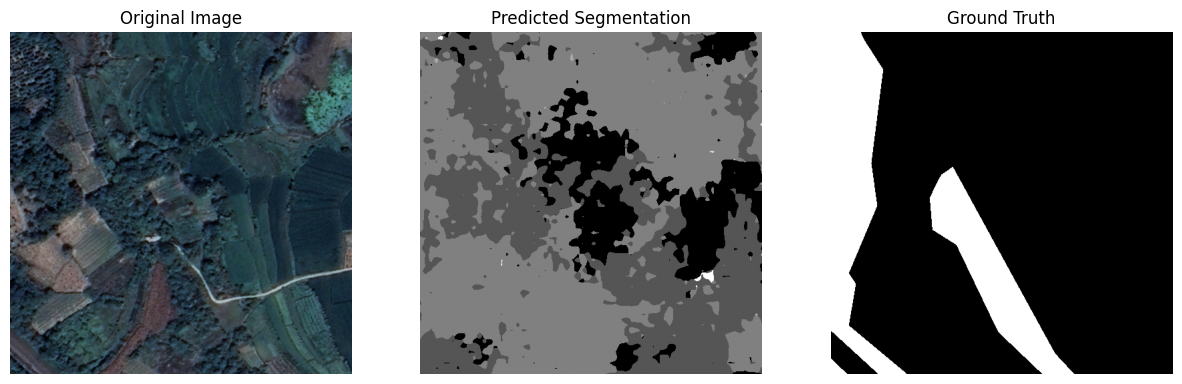

Params: 7.718 M


In [ ]:
"""
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import random

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    # Prendi un'immagine random dal validation set
    random_index = random.randint(0, len(val_dataset) - 1)
    X, y, boundary_mask = val_dataset[random_index]

    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device).unsqueeze(dim=0)
    boundary_mask = boundary_mask.to(device).unsqueeze(dim=0)

    start = timer()
    outputs = model(X)
    end = timer()

    latency = end - start

    ## Upscale trough bilinear interpolation
    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    print(f"h: {h} | w: {w} | ph: {ph} | pw: {pw}")
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

    # Se augment=True, gestiamo i diversi output
    if model.augment:
        pred_p, pred_main, boundary_head = outputs
    else:
        pred_main = outputs
        boundary_head = None

    # Calcolo dei FLOPs
    flops = FlopCountAnalysis(model, X.clone())

    # Softmax per normalizzare le predizioni
    normalized_masks = torch.nn.functional.softmax(pred_main, dim=1)

    # Selezione delle predizioni per ciascuna classe
    masks = [
        normalized_masks[0, sem_class_to_idx[cls]]
        for cls in SEM_CLASSES
    ]

    print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
    print(f"Average inference latency is {latency:.3f} seconds.")

    # Converti output e ground truth per la visualizzazione
    out = pred_main.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
    y_np = y.squeeze().cpu().numpy()  # Ground truth
    X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

    # Creazione della figura con tre immagini affiancate
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine originale
    axes[0].imshow(X_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predizione del modello
    axes[1].imshow(out, cmap="gray")
    axes[1].set_title("Predicted Segmentation")
    axes[1].axis("off")

    # Ground truth
    axes[2].imshow(y_np, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.show()

    # Conta i parametri del modello
    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params / 1e6:.3f} M")
"""

In [ ]:
"""
 # **Validazione**
model.eval()
val_loss = 0
miou.reset()

total_val_samples = 0

with torch.inference_mode():
    for X_val, y_val, boundary_mask in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X_val)

        ## Upscale trough bilinear interpolation
        h, w = boundary_mask.size(1), boundary_mask.size(2)
        ph, pw = outputs[0].size(2), outputs[0].size(3)
        if ph != h or pw != w:
            for i in range(len(outputs)):
                outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

        if model.augment:
            pred_p, pred_main, boundary_head = outputs
        else:
            pred_main = outputs
            boundary_head = None

        # Converte le predizioni nei valori di classe più probabili
        preds = torch.argmax(pred_main, dim=1)


        target_one_hot = F.one_hot(y_val+1, num_classes=num_classes+1)

        target_one_hot = target_one_hot[:, :, :, 1:] -1 # Shape: [8, 16, 16, 7]

        # Permute to get (N, C, H, W)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).bool()


        pred_miou = F.one_hot(pred_main.argmax(dim=1), num_classes=num_classes).permute(0, 3, 1, 2).to(torch.bool)  # Shape: [8, 7, 16, 16]
        #avg_miou = pred_main.mean()

        # Converte le predizioni nei valori di classe più probabili
        #preds = torch.argmax(pred_main, dim=1)

        miou.update(preds=pred_miou, target=target_one_hot)

        # Calcola la loss
        loss = loss_fn(pred_main, y_val, boundary_head, boundary_mask)

        val_loss += loss.item()

        total_val_samples += X_val.size(0)

avg_val_loss = val_loss / total_val_samples

miou_per_class = miou.compute()  # Returns a tensor with per-class IoU
miou_per_class_str = ", ".join([f"Class {i}: {iou:.4f}" for i, iou in enumerate(miou_per_class)])
print(f"Validation Loss: {avg_val_loss} - avg mIoU: {avg_miou} - mIoU per class: {miou_per_class_str}")
"""